<a href="https://colab.research.google.com/github/deep-diver/keras-sd-serving/blob/main/fastapi_all_in_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastapi
!pip install "uvicorn[standard]"
!pip install keras-cv
!pip install nest-asyncio pyngrok

In [ ]:
%%writefile main.py
import json
import base64
import urllib.request

import keras_cv
from fastapi import FastAPI, File, Form, HTTPException

app = FastAPI()

@app.on_event("startup")
def load_modules():
 global stable_diffusion
 stable_diffusion = keras_cv.models.StableDiffusion(img_width=512, img_height=512)

@app.post("/image/generate")
async def image_generate(
  prompt: str = "photograph of an astronaut riding a horse", 
  batch_size: int = 1):
  
  images = stable_diffusion.text_to_image(prompt, batch_size=batch_size)
  return {"images": base64.b64encode(images.tobytes()).decode()}

Writing main.py


In [116]:
%%bash --bg
nohup uvicorn main:app --port 80 > nohup.log 2>&1 &

In [117]:
import json
import requests as r

ENDPOINT_URL = "http://127.0.0.1/image/generate"
PROMPT = "photograph of an astronaut riding a horse"
BATCH_SIZE = 4

payload = {"prompt": PROMPT,
           "batch_size": 4}

headers = {"Content-Type": "application/json"}

response = r.post(ENDPOINT_URL, headers=headers, params=payload)

In [122]:
response

<Response [200]>

In [125]:
import base64
import json
import numpy as np

contents = json.loads(response.content)

decoded = base64.b64decode(contents["images"])
restored = np.frombuffer(decoded, dtype="uint8")
restored_reshaped = np.reshape(restored, (BATCH_SIZE, 512, 512, 3))

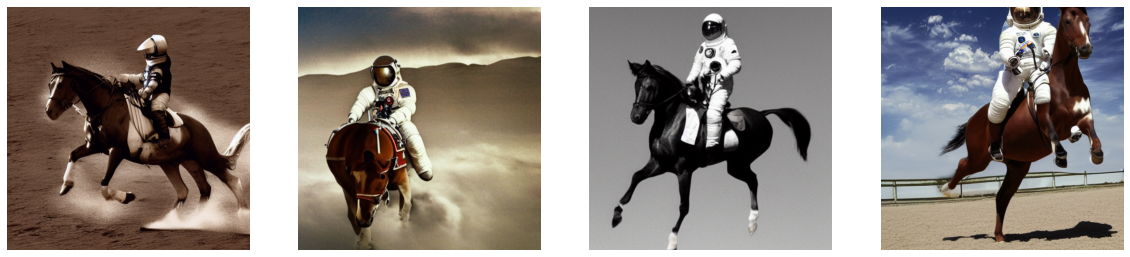

In [126]:
import matplotlib.pyplot as plt

def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

plot_images(restored_reshaped)

In [114]:
!ps aux | grep uvicorn

root       27933 38.7 19.9 28398272 5325828 ?    Sl   15:50   2:16 /usr/bin/python3 /usr/local/bin/uvicorn main:app --port 80
root       29691  0.0  0.0  39204  6584 ?        S    15:56   0:00 /bin/bash -c ps aux | grep uvicorn
root       29693  0.0  0.0  38580  5644 ?        S    15:56   0:00 grep uvicorn


In [115]:
!kill 27933